# Arbitrary Fit - 1D

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import math
from math import *
from numpy.linalg import inv, solve
from qutip import *

In [41]:
nMax = 5

In [42]:
def importData1(fname):
    timeTickFirst, timeTickLast, x, \
    ion1, ion1_raw, ion1_bottom, ion1_top, \
    ion2, ion2_raw, ion2_bottom, ion2_top, \
    ion3, ion3_raw, ion3_bottom, ion3_top, \
    ion4, ion4_raw, \
    ion5, ion5_raw = np.genfromtxt(fname, delimiter="\t",comments="#", unpack="True", encoding='latin1')
    return x, ion3

def importData2(fname):
    timeTickFirst, timeTickLast, x, ion1, ion1_raw, ion1_bottom, ion1_top, ion2, ion2_raw, ion2_bottom, \
    ion2_top = np.genfromtxt(fname, delimiter="\t",comments="#", unpack="True", encoding='latin1')
    return x, ion2

def importData3(fname):
    timeTickFirst, timeTickLast, x, PMT1, PMT1_raw, PMT1_bottom, PMT1_top, PMT2, PMT2_raw, PMT2_bottom, PMT2_top\
    = np.genfromtxt(fname, delimiter="\t",comments="#", unpack="True", encoding='latin1')
    return x, PMT1

def sinfit(t, a, w):
    return a*np.sin(w*t)**2

def coherent_fit(t, a, w, alpha):
    result = 0
    for n in range(nMax):
        result += alpha**(2*n)/(math.factorial(n))*a*np.sin(np.sqrt(n+1)*w*t)**2
    return np.exp(-alpha*alpha)*result

def coherent_push(alpha, nMax):
    return (alpha*create(nMax)-np.conj(alpha)*destroy(nMax)).expm()

0.2907007482934196


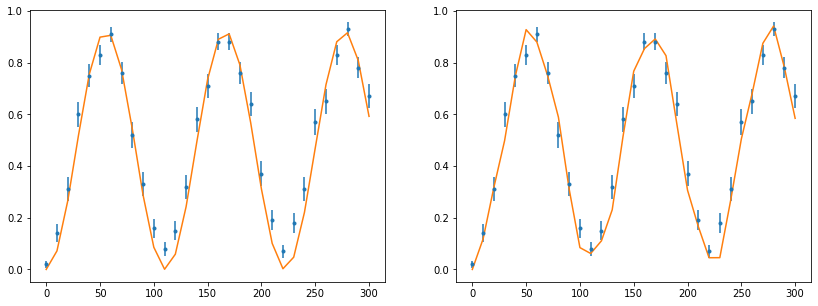

In [43]:
# Fitting push distance
# Quick check on initial guess for a and omega
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

gs = 'RamanTimeScan_BSB11_001'
t, y = importData3(gs)
y_err = np.sqrt(y*(1-y)/100+1e-6)
Initial_guess = [1, np.pi*4/5]
# print(y_err)
a_0, w_0 = opt.curve_fit(sinfit, t, y, Initial_guess, sigma=y_err, absolute_sigma=True)[0]
ax[0].errorbar(t, y, y_err, fmt='.')
ax[0].plot(t, sinfit(t, a_0, w_0))

g_push = 'RamanTimeScan_BSB11_001'
tg, yg = importData3(g_push)
yg_err = np.sqrt(yg*(1-yg)/100+1e-6)
# print(yg_err)
a, w, alpha = opt.curve_fit(coherent_fit, tg, yg, [a_0, w_0, 0.8], sigma=yg_err, absolute_sigma=True)[0]
ax[1].errorbar(tg, yg, yg_err, fmt='.')
ax[1].plot(tg, coherent_fit(tg, a, w, alpha))

print(alpha)

In [44]:
# Check ideal case, initial guess
def TimeScan(psi, t, Omega=1, length=101):
#     nSample = nMax
    H = Omega*(tensor(create(nMax), sigmap())+tensor(destroy(nMax), sigmam()))
#     H = Omega*tensor((create(nMax)+destroy(nMax)), (sigmap()+sigmam()))
    result = mesolve(H, psi, np.linspace(0, t, length), [], tensor(qeye(nMax), ket2dm(basis(2, 0))))
    return result.expect[0]

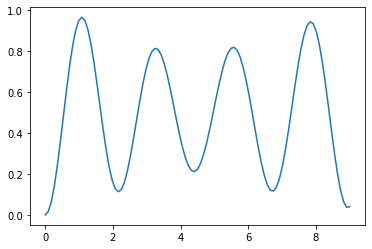

In [45]:
t = 9
psi0 = tensor(coherent_push(alpha, nMax)*fock(nMax, 1), fock(2, 1))
y = TimeScan(psi0, t)
plt.plot(np.linspace(0, t, 101), y)

Initial_guess = ket2dm(coherent_push(alpha, nMax)*fock(nMax, 1)).diag()
# Initial_guess

In [46]:
t, y = importData3('RamanTimeScan_BSB11_001')
# len(y)

In [47]:
# # Quick check on initial guess for a and omega
# gs = 'CI_RamanTimeScan_CounterProp_BSB_Tilt_001'
# t, y = importData2(gs)
# Initial_guess = [1, np.pi*4]
# a, w_0 = opt.curve_fit(sinfit, t, y, Initial_guess)[0]
# plt.plot(t, y, '.')
# plt.plot(t, sinfit(t, a, w_0))

In [48]:
# g1 = 'CI_RamanTimeScan_CounterProp_BSB_Tilt_008'
# t, y2 = importData2(g1)
# plt.plot(t, y2, '.')
# ket2dm(coherent_push(alpha, nMax)*fock(nMax, 1)).diag()

In [49]:
# bounds_l = ([-inf, -inf]+(np.zeros(nMax-1).tolist()))
# bounds_u = ([inf, inf]+(np.ones(nMax-1).tolist()))
bounds = ([-inf, inf], [-inf, inf])+tuple([[0, 1]]*(nMax-1))

In [50]:
def getDiag(data, gs_data=gs, is5ion=False, origin=False):
    # Get base omega for ground state
    t, y = importData3(gs_data)
    t = t[:61]
    y = y[:61]
#     Initial_guess = [1, 3*np.pi]
#     a, w_0 = opt.curve_fit(sinfit, t, y, Initial_guess)[0]
    y_err = np.sqrt(y*(1-y)/100+1e-6)
    Initial_guess = [1, np.pi*4/5]
    # print(y_err)
    a, w_0 = opt.curve_fit(sinfit, t, y, Initial_guess, sigma=y_err, absolute_sigma=True)[0]
    
    # Read data
    y_data = importData3(data)[1]
#     if is5ion==False:
#         y_data = importData2(data)[1][:61]
#     else:
#         y_data = importData1(data)[1]

    # Initial guess
    aStart = ket2dm(fock(nMax, 0)).diag()
    if origin==True:
        aStart = np.zeros(nMax)
        aStart[1] = 1
    guess_0 = [a, w_0] + aStart.tolist()[:-1]
    
    # Curve for given amp list
    def y_fitted(guess):
        result = 0
        if (len(guess)-2==nMax-1):
            for i in range(nMax-1):
                result += guess[i+2]*(np.sin(np.sqrt(i+1)*guess[1]*t))**2
            result += (1-np.sum(guess[2:]))*np.sin(np.sqrt(nMax+1)*guess[1]*t)**2
        result *= guess[0]
        return t, result

    # Optimized function, R^2 = \Sum{(ydata-yfit)^2}
    def R_2(amp):
        y_fit = y_fitted(amp)[1]
        res = y_data-y_fit
        result = np.sum(res**2)
        return result
        
    # Reduced chi-square
    def chi_2(amp):
        y_fit = y_fitted(amp)[1]
        res = y_data-y_fit
        dev_m = y_data*(1-y_data)/100+1e-5
        chi_2 = np.sum(res**2/dev_m)/(len(y_data)-11)
        return chi_2
    
    # Optimization and print coefficients
    fit = opt.minimize(R_2, guess_0, bounds=bounds)
#     if np.abs(chi_2(fit.x)-1) > 0.5:
# #         aStart = coherent_dm(nMax, alpha).diag().real[:-1]
#         aStart = np.zeros(nMax-1)
#         aStart[0] = 0.5
#         aStart[1] = 0.5
#         guess_0 = [a, w_0] + aStart.tolist()
#         fit = opt.minimize(R_2, guess_0)
    r2 = 1-fit.fun/(np.sum((y_data-np.mean(y_data))**2))
    chi2 = chi_2(fit.x)
#     print('A =', fit.x[0])
#     print('omega =', fit.x[1])
#     print('r^2 =', r2)
#     print('chi^2 =', chi2)
#     print('---------------------------------------------------')
    
    # Plot
#     print(fit.x[2:])

    if np.abs(chi2) > 0:
        fig, ax = plt.subplots(1, 1, figsize = (8, 5))
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(16)
        ax.plot(t, y_data, 'o', label = 'Data')
        ax.plot(t, y_fitted(fit.x)[1], label = 'Fit, $\chi^2$=%.3f' %chi2)
        ax.set_xlabel('Time(us)', fontsize=16)
        ax.set_ylabel('Probability', fontsize=16)
        ax.legend(fontsize=16)
        ax.set_ylim([-0.05, 1])
        ax.set_title(data, fontsize=20)
        
    
    # Return DM diagonal terms
    arr = fit.x[2:]
    diag = np.append(arr, max(0, 1-np.sum(arr)))
    return diag

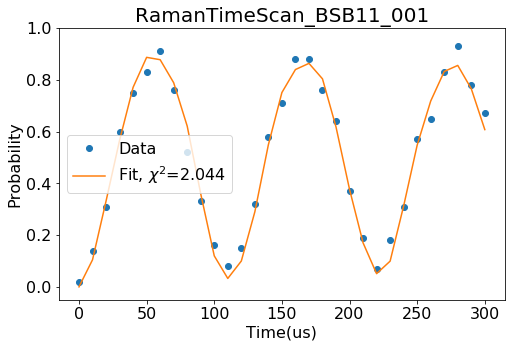

In [51]:
n = getDiag('RamanTimeScan_BSB11_001', 'RamanTimeScan_BSB11_001')

In [52]:
nbar = np.sum([i*n[i] for i in range(len(n))])
nbar

0.43606876068614797

In [53]:
n

array([0.85518364, 0.02325225, 0.        , 0.07343995, 0.04812416])

## Test

### Wigner

In [13]:
def Wigner(diag):
    W = 0
    for i in range(nMax):
        W += (-1)**i*diag[i]
    return W

In [14]:
F_ref = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_005')   
F_1 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_006')   # 0
F_2 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_007')   # 45
F_3 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_008')   # 90
F_4 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_009')   # 135
F_5 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_010')   # 180
F_6 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_011')   # 225
F_7 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_012')   # 270
F_8 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_013')   # 315
# F_9 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_014')   # only 0.3 ms push

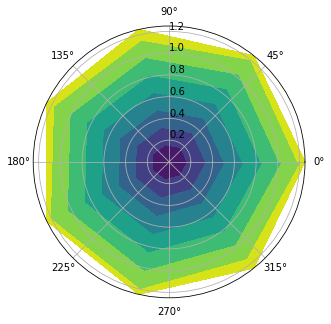

In [15]:
plt.figure(figsize=(5, 5))
ax = plt.subplot(111, polar=True)
phi = np.linspace(0, 2*np.pi, 8)
r = np.linspace(0, 1.25, 2)

r, theta = np.meshgrid(r, phi)
origin = (np.ones(8)*Wigner(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_005', origin=True))).reshape(8,1)
# origin = (np.ones(8)*(-1)).reshape(8,1)

data = [[Wigner(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_009',))],
       [Wigner(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_010'))],
       [Wigner(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_012'))], 
       [Wigner(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_013'))],
       [Wigner(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_011'))],
       [Wigner(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_006'))],
       [Wigner(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_007'))],
       [Wigner(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_008'))]]

data = np.array(data)

data = np.concatenate([origin, data], axis=1)
ax.contourf(theta, r, data)
ax.set_rlabel_position(90)
# ax.set_rgrids([0,1.25])
# plt.savefig('wigner.pdf')

### QST

In [16]:
nMeas = 8

In [17]:
def gamma_vec(k, n, l, alpha):
    prefactor = exp(-abs(alpha)**2)*abs(alpha)**(2*k)/(float(factorial(k)))
    sum_term = 0
    for i in range(min(k,n)+1):
        for j in range(min(k,l+n)+1):
            sum_term += abs(alpha)**(2*(n-j-i)+l)*(-1)**(-j-i)*comb(k,j)*comb(k,i)\
                        *sqrt(factorial(l+n)*factorial(n))/(factorial(l+n-j))/factorial(n-i)
    return prefactor*sum_term

def gamma_mat(kmax, nmax, l, alpha):
    assert(abs(l)<=nmax)
    ans = np.ones(nmax*kmax).reshape(kmax,nmax)
    for k in range(kmax):
        n_id = 0
        for n in range(max(0,-l),max(0,-l)+nmax):
            ans[k,n_id]=gamma_vec(k,n,l,alpha)
            n_id += 1
    return ans

In [18]:
def getQ_k_l(QKD):
    nSample = nMeas//2
    coeff = []
    for l in range(0, nSample):
        temp = []
        for p in range(-nSample, nSample):
            temp.append(np.exp(-1j*l*np.pi*p/nSample))
        coeff.append(np.array(temp))
    return (np.dot(np.array(coeff),QKD)/2/nSample).transpose()

def gamma_list(l, alpha):
    result = np.ones((nMax, nMax), dtype=complex)
    for k in range(nMax):
        c_k = np.exp(-alpha**2)*alpha**(2*k)/math.factorial(k)
        for n in range(nMax):
            temp = 0
            for j_p in range(0, min(k, n)+1):
                for j in range(0, min(k, l+n)+1):
                    temp += alpha**(2*(n-j-j_p)+l)*(-1)**(-j-j_p)*math.comb(k, j)*math.comb(k, j_p)\
                    *np.sqrt(np.float(math.factorial(l+n)*math.factorial(n)))/(math.factorial(l+n-j)*math.factorial(n-j_p))
            result[k, n] = temp*c_k
    return result

def reconstruct(Q_arr, alpha, Nmax=nMeas//2):
    ans = 0
    for l in range(-Nmax+1,Nmax):
        ans += np.diag(solve(gamma_mat(kmax=Nmax,nmax=Nmax,l=l,alpha=alpha),getQ_k_l(Q_arr)[:,l])[:Nmax-abs(l)],k=l)
    return Qobj(ans)

def getState(qList, alpha, dim=nMeas//2):
    result = np.zeros([dim, dim], dtype=complex)
    for i in range(0, dim):
        diag = np.dot(inv(gamma_list(i, alpha)), getQ_k_l(qList)[:, i])
        for j in range(0, dim-i):
            result[j][i+j] = diag[j]
            if (i!=0):
                result[i+j][j] = np.conj(diag[j])
    return Qobj(result)


In [19]:
F_ref = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_005')   
F_1 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_006')   # 0
F_2 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_007')   # 45
F_3 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_008')   # 90
F_4 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_009')   # 135
F_5 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_010')   # 180
F_6 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_011')   # 225
F_7 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_012')   # 270
F_8 = importData2('CI_RamanTimeScan_CounterProp_BSB_Tilt_013')   # 315
# F_9 = importData1('CI_RamanTimeScan_CounterProp_BSB_Tilt_004')   # only 0.3 ms push

getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_009')

array([0.27136176, 0.09931538, 0.31892405, 0.20401328, 0.05842352,
       0.01005031, 0.        , 0.        , 0.03153842, 0.00637328])

In [20]:
# QKD
qList_out = []
qList_out.append(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_009'))
qList_out.append(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_010'))
qList_out.append(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_012'))
qList_out.append(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_013'))
qList_out.append(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_011'))
qList_out.append(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_006'))
qList_out.append(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_007'))
qList_out.append(getDiag('CI_RamanTimeScan_CounterProp_BSB_Tilt_008'))

In [21]:
# qList_in = []
# qList_in.append(getDiag('displacement_test_003'))
# qList_in.append(getDiag('displacement_test_004'))
# qList_in.append(getDiag('displacement_test_005'))
# qList_in.append(getDiag('displacement_test_006'))
# qList_in.append(getDiag('displacement_test_007'))
# qList_in.append(getDiag('displacement_test_008'))
# qList_in.append(getDiag('displacement_test_009'))
# qList_in.append(getDiag('displacement_test_010'))
alpha=0.7863 #nM=10
# alpha=0.5
state = getState(qList_out, alpha)/(sum(getState(qList_out, alpha).diag()))

In [22]:
state

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.07537715+0.j         -0.00275137-0.02778012j -0.02778297+0.01082057j
  -0.05609596-0.01549145j]
 [-0.00275137+0.02778012j  0.8789387 +0.j         -0.01419826+0.03068505j
  -0.02380988+0.02444944j]
 [-0.02778297-0.01082057j -0.01419826-0.03068505j  0.04460797+0.j
  -0.01767296-0.01061336j]
 [-0.05609596+0.01549145j -0.02380988-0.02444944j -0.01767296+0.01061336j
   0.00107618+0.j        ]]

In [23]:
# state2 = reconstruct(qList_out, alpha)

<ipython-input-24-ee9473a3a58b>:10: UserWarning: The following kwargs were not used by contour: 'figsize'
  im = ax.contourf(xvec, xvec, wigner(state, xvec, xvec)-W_exp, 100, figsize=(5, 5))


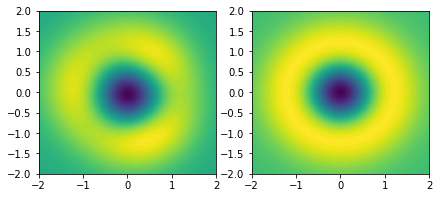

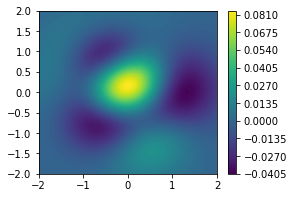

In [24]:
xvec = np.linspace(-2, 2, 201)
W_exp = wigner(fock(4, 1), xvec, xvec)
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
# axes.matshow(wigner(getState(qList_out, 0.6), xvec, xvec))
im1 = axes[0].contourf(xvec, xvec, wigner(state, xvec, xvec), 100)
# plt.colorbar(im1)
im2 = axes[1].contourf(xvec, xvec, W_exp, 100)
# plt.colorbar(im2)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
im = ax.contourf(xvec, xvec, wigner(state, xvec, xvec)-W_exp, 100, figsize=(5, 5))
plt.colorbar(im)

In [26]:
# fidelity(state, fock_dm(4, 1))

In [135]:
# xvec = np.linspace(-2, 2, 200)
# W_exp = wigner(fock(5, 1), xvec, xvec)

In [136]:
# fig, axes = plt.subplots(1, 1, figsize=(5, 5))
# cont0 = axes.contourf(xvec, xvec, W_exp, 100)